<a href="https://colab.research.google.com/github/Ceciliawangwang/Tutorial_image_segmentation_Unet/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation tutorial

## 1. Introduction

In this tutorial, we will apply the U-Net architecture in Pytorch to train an image semantic segmentation model. The objectives of this tutorial are:

*   Understand the fundamentals of U-Net architecture
*   Load and preprocess data (images and masks/labels) in Pytorch
*   Train an U-Net semantic sgementation model
*   Predict segmentation results using the trained model

In order to showcase the overall model construction and training processes,a small dataset will be used in PyTorch. However, training a machine learning model on larger datasets may lead to better performance.

***Note***: Keep in mind that training a model on a larger dataset may require more computing resources and may take longer to train, so it's important to consider these factors when deciding on the size of your dataset.

## 2. Configure environment

**2.1 Get start with Google Colab**

In this tutorial, we will access to a pre-configured Jupyter Notebooks running on *Google Colaboratory* : https://colab.research.google.com/

It is a free, cloud-based development environment provided by Google. It allows users to write and run Python code in a web browser, with access to powerful computing resources such as GPUs and TPUs.

**2.2 Mount the Google Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2.3 Import libraries**

To follow this tutorial, you need to have the following libraries installed.  

*   os
*   numpy
*   PIL / OpenCV
*   PyTorch
*   matplotlib


As we are using colab, we do not need to install these libraries manually. If you are working locally, please ensure configure all the required libraries.

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision import models
# from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

in this tutorial we will use GPU to speed up the trainning process of the image segmentaion. Here is the settings in Google Colaboratory:
`Runtime >> Change runtime type >> Hardware accelerator >> GPU`

Test the connect of gpu resources, please type in the `torch.cuda.is_available()`

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## 3. Hyperparameters
Before go into the model training, we will firstly introduce the *Hyperparematers*, as settings of different hyperparameters may affect the final result. Heperparameters are configuration variables that are set prior to training a machine learning model.  These variables are specified by the user, rather than learned from the training data.You can try different parameters and observe the changes of model performance.

Here, we defined following hyperparameters:

`BATCH_SIZE` refers to the number of images that are fed into the neural network at once during the model training.

`LEARNING_RATE` determines the step size taken by the optimization algorithm during the training process. Normally, we choose value from 0.001 to 0.01.

`NUM_EPOCHS` specifies the number of times the model should go through the entire training dataset.


In [ ]:
BATCH_SIZE = 2
LEARNING_RATE = 0.01
NUM_EPOCHS = 20

NUM_WORKERS = 2 # According to memory

## 4. Dataset

**4.1 Dataset**

In this tutorial, we will use data from: https://github.com/VikramShenoy97/Human-Segmentation-Dataset

Existing labelled dataset:

*   PASCAL VOC 2012 Segmentation Competition
*   COCO 2018 Stuff Segmentation Task
*   BDD100K: A Large-scale Diverse Driving Video Database
*   Cambridge-driving Labeled Video Database (CamVid)
*   Cityscapes Dataset
*   Mapillary Vistas Dataset
*   ApolloScape Scene Parsing


**Folder structure**

After downloading the images and masks, please organize your data by following structure manually. In order to get better performance, the ratio for training data and validation data is 8:2.

```
root/
    train/
        image/
            image1.jpg
            image2.jpg
            ...
        mask/
            mask1.png
            mask2.png
            ...
    val/
        image/
            image1.jpg
            image2.jpg
            ...
        mask/
            mask1.png
            mask2.png
            ...
    test/
        image/
            image1.jpg
            image2.jpg
            ...
        mask/
            mask1.png
            mask2.png
            ...    
    output/

```



Images and masks in `train` and `val` folders will be used during the model training process and data in test will be used based on a trained model. The `output `folder is built to save results, such as the model `.pth` files, change of loss figures and segmented images.

In [ ]:
# Training
TRAIN_IMG_DIR = '/content/drive/MyDrive/dataset0/train/image'
TRAIN_MASK_DIR = '/content/drive/MyDrive/dataset0/train/mask'
# Validation
VAL_IMG_DIR = '/content/drive/MyDrive/dataset0/val/image'
VAL_MASK_DIR = '/content/drive/MyDrive/dataset0/val/mask'
# Testing
TEST_IMG_DIR = '/content/drive/MyDrive/dataset0/test/image'
TEST_MASK_DIR = '/content/drive/MyDrive/dataset0/test/mask'
# Output
OUTPUT_PATH = 'drive/MyDrive/dataset0/output/'

**4.2 Prepare data**

Create a Class `CustomDataset` to organize dataset for training, validation and testing.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


`__init__()` refers to the image location

`__len__()` is the length of the dataset

`__getitem__() `loads an image and mask

Note: transfer the mask value to 1, and the background is 0.

**Transformations**

Then, we define the transform fuctions for the training dataset and validation datset individually. In these functions, we resize the image and convert the image to a tensor for the preparation for dataloader.

In [ ]:
# define the input image dimensions
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240

train_transform = A.Compose(
      [   A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Rotate(limit=35, p=1.0),  #
          A.HorizontalFlip(p=0.5),   #
          A.VerticalFlip(p=0.1),   #
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),], is_check_shapes=False)

val_transforms = A.Compose(
    [   A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),], is_check_shapes=False)

**4.3 Dataloaders**

Here we create a function to initialise the Pytorch dataset and create the dataloaders.

In [ ]:
# initialize dataset
train_ds = CustomDataset(image_dir=TRAIN_IMG_DIR,
                         mask_dir=TRAIN_MASK_DIR,
                         transform=train_transform)
val_ds = CustomDataset(image_dir=VAL_IMG_DIR,
                       mask_dir=VAL_MASK_DIR,
                       transform=val_transforms)

# create dataloader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True,)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False,)


## 5. Fundamental of U-Net


The U-Net architecture is a deep learning model that was introduced by Ronneberger et al. in 2015 for image segmentation. The U-Net architecture has a symmetric encoder-decoder structure that enables it to accurately segment images with high resolution, even in cases where the object of interest occupies only a small portion of the image.

**5.1 Structure of U-Net**


Paper  https://arxiv.org/abs/1505.04597
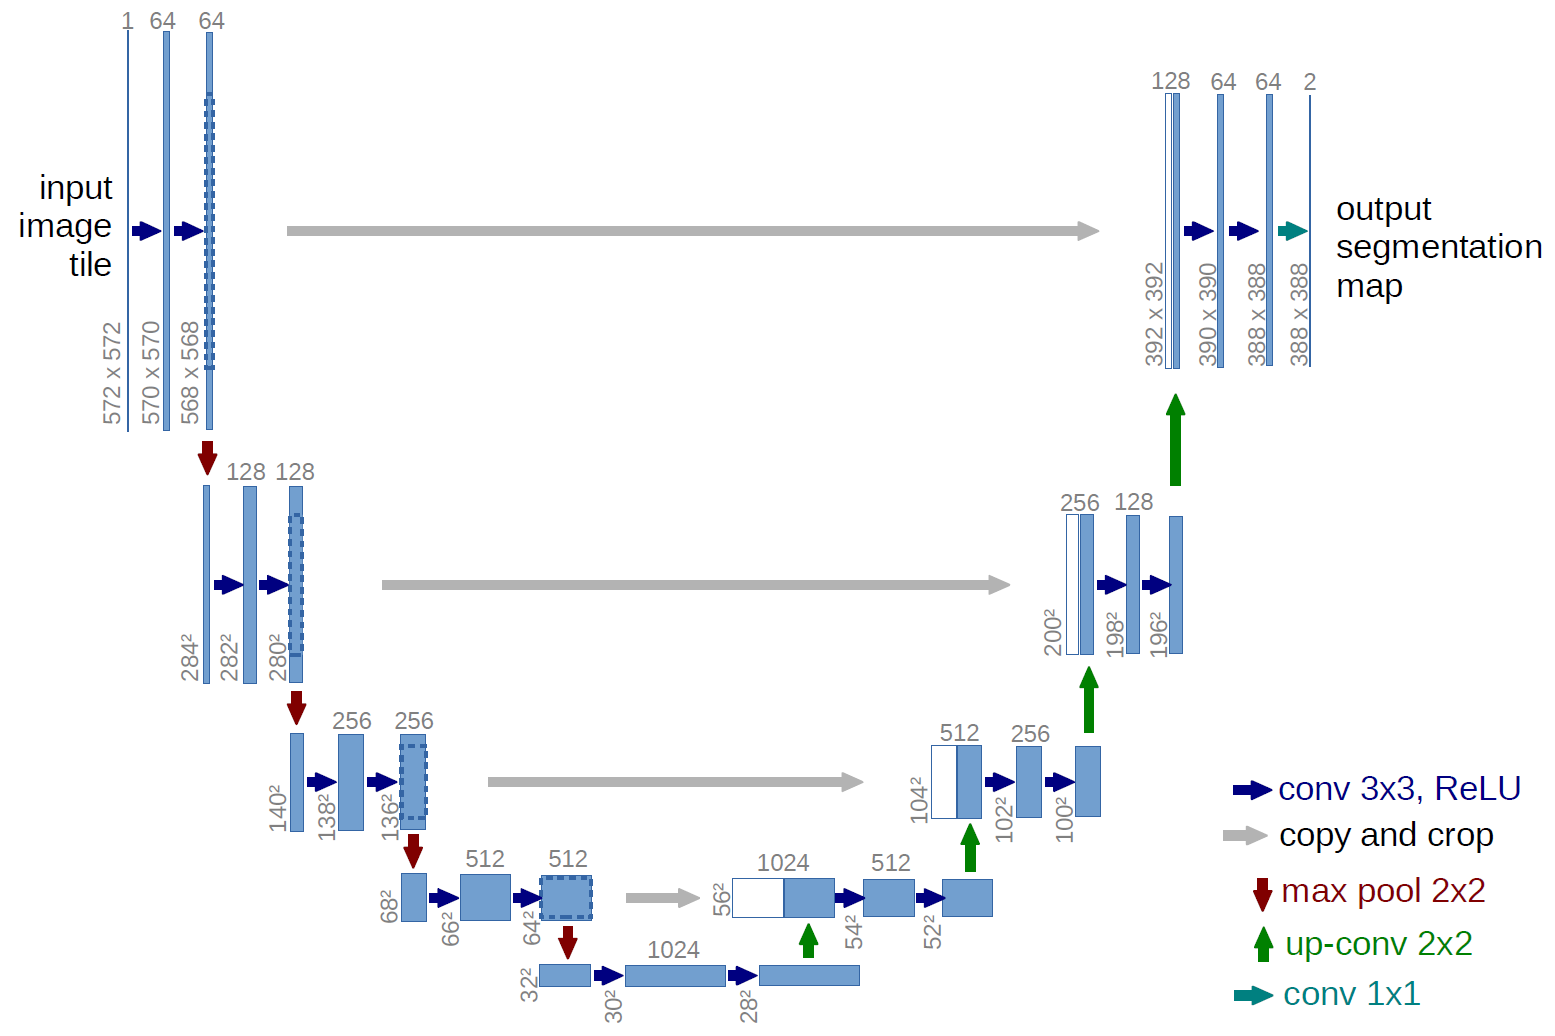

**Encoder and decoder**

The encoder network of the U-Net architecture is designed to extract the features from the input image and compress them into a lower-dimensional representation. The encoder typically consists of a series of convolutional and pooling layers that progressively reduce the spatial dimensions of the feature maps. The convolutional layers extract the relevant features from the input image, while the pooling layers reduce the spatial dimensions of the feature maps while preserving their most important features.

The decoder network of the U-Net architecture is designed to reconstruct the segmented image from the low-dimensional representation produced by the encoder network. The decoder network typically consists of a series of deconvolutional layers that gradually increase the spatial dimensions of the feature maps. Each deconvolutional layer is followed by an up-sampling operation that increases the spatial resolution of the feature maps. The feature maps are then concatenated with the corresponding feature maps from the encoder network using skip connections, which allow for precise localization of the segmented objects.

The skip connections in U-Net are a key feature that enables it to accurately localize objects in the image. These connections pass the feature maps from the encoder network directly to the corresponding layer in the decoder network, allowing the decoder network to use the high-level features extracted by the encoder network for precise localization of the segmented objects.


**5.2 Build U-Net architecture**

First, we define the convolution block `DoubleConv`. It includes two 3*3 convolution layers and each followed by a batch normalization and a ReLU activation.

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


Then, we construct the entire architecture of U-Net. The `forward` function defines the sequence of operations that are performed on the input data to produce the output.
The *encoder block* consists.

The *docder block *begins with a transpose convolution `ConvTranspose2d()`, followed by a concatenation with the skip connection from the encoder block.

In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET/Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET/Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


## 6. Train the model

**6.1 Initialize the model and training parameters**

After constructing the architecture of U-Net, we initialize the model, loss function, and the optimizer. For the loss function, we choose `BCEWithLogitsLoss()` for image binary segmentation. If we have more than 2 classes, we can consider `CrossEntropyLoss()` as a loss function.


In [ ]:
# initialize model and training parameters
unet = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)

**6.2 Training loop and model evaluation**

Then, we calculate *Dice* coefficient (F1 score), which is a metric used to evaluate the similarity between two sets. The Dice coefficient ranges from 0 to 1, where a value of 1 indicates a perfect match between the predicted and ground truth segmentation masks, and a value of 0 indicates no overlap at all. Therefore, a higher Dice coefficient value indicates better segmentation performance.

In [ ]:
 # training loop
H = {"train_loss": [], "val_loss": []}
for epoch in range(NUM_EPOCHS):

    # set the model in training mode
    unet.train()

    # initialize the total training and validataion loss
    train_loss = 0
    val_loss = 0

    # loop over the training set
    for (bx, (x, y)) in enumerate(train_loader):
        # send the input to the device
        x = x.to(DEVICE)
        y = y.unsqueeze(1).float().to(DEVICE)  # (1, 160, 240) >> (1, 1, 160, 240)

        # perform a forward pass and calculate the training loss
        optimizer.zero_grad()    # zero the praramter gradients
        preds = unet(x).to(DEVICE)
        loss = loss_fn(preds, y)


        # backward + optimize only if in training phase
        loss.backward()  # backpropagation
        optimizer.step() # update all the parameters
        train_loss += loss.item()  # .item() return the value back to cpu


    train_loss /= len(train_loader)

    unet.eval()
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    val_loss = 0
    with torch.no_grad():
        # loop over the validation set
        for (x, y) in val_loader:
            # send the input to the device
             x = x.to(DEVICE)
             y = y.unsqueeze(1).float().to(DEVICE)

            # make the predictions and calculate the validation loss
             preds = unet(x)
             loss = loss_fn(preds, y)
             val_loss += loss.item()

            # check accuracy
             preds_prob = torch.sigmoid(unet(x))  # apply the sigmoid function, return the predicted probabilities for each class.
             preds_prob = (preds_prob > 0.5).float()  # converts the predicted probabilities to binary predictions by thresholding at 0.5
             num_correct += (preds_prob == y).sum()
             num_pixels += torch.numel(preds_prob)
             dice_score += (2 * (preds_prob * y).sum()) / ((preds_prob + y).sum() + 1e-8)


    val_loss /= len(val_loader)
    accuracy = num_correct/num_pixels
    f1 = dice_score/len(val_loader)


    H["train_loss"].append(train_loss)
    H["val_loss"].append(val_loss)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, NUM_EPOCHS))

    print("Train loss: {:.4f}, Validation loss: {:.4f}".format(train_loss, val_loss))
    print('Accuracy: {:.2f}%, '.format(accuracy*100), 'F1 score: {:.4f}'.format(f1))


    # save the model
    torch.save(unet, os.path.join(OUTPUT_PATH) + 'unet_{}.pth'.format(epoch + 1))

[INFO] EPOCH: 1/20
Train loss: 0.5153, Validation loss: 0.8579
Accuracy: 65.88%,  F1 score: 0.3167
[INFO] EPOCH: 2/20
Train loss: 0.5150, Validation loss: 0.7205
Accuracy: 67.85%,  F1 score: 0.4676
[INFO] EPOCH: 3/20
Train loss: 0.5521, Validation loss: 0.6046
Accuracy: 68.06%,  F1 score: 0.5023
[INFO] EPOCH: 4/20
Train loss: 0.5107, Validation loss: 0.6481
Accuracy: 55.35%,  F1 score: 0.4647
[INFO] EPOCH: 5/20
Train loss: 0.5434, Validation loss: 0.6710
Accuracy: 63.50%,  F1 score: 0.2397
[INFO] EPOCH: 6/20
Train loss: 0.5000, Validation loss: 0.7174
Accuracy: 54.69%,  F1 score: 0.4597
[INFO] EPOCH: 7/20
Train loss: 0.4945, Validation loss: 0.8581
Accuracy: 53.12%,  F1 score: 0.5229
[INFO] EPOCH: 8/20
Train loss: 0.5142, Validation loss: 0.8257
Accuracy: 57.34%,  F1 score: 0.5620
[INFO] EPOCH: 9/20
Train loss: 0.4573, Validation loss: 0.7512
Accuracy: 70.85%,  F1 score: 0.5643
[INFO] EPOCH: 10/20
Train loss: 0.4917, Validation loss: 1.4053
Accuracy: 46.88%,  F1 score: 0.4542
[INFO] EP

In order to better observe change of loss over epochs during the training loop, we use matplot to visualize the loss. Following is the figure  an example to show the loss curves.

Besides, we could use `tensorboard` to monitor the training process. If you are interested, you may find this material useful: https://pytorch.org/docs/stable/tensorboard.html

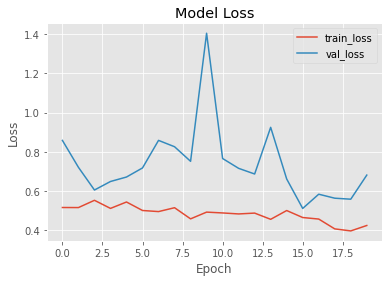

In [ ]:
# plot the training loss
import matplotlib.pyplot as plt

# PLOT_PATH = 'drive/MyDrive/dataset0/output/loss_2.png'
# MODEL_PATH = 'drive/MyDrive/dataset0/output/unet.pth'
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(os.path.join(OUTPUT_PATH + 'model_loss.png'))
# serialize the model to disk
#btorch.save(unet, MODEL_PATH)

## 7. Predict results on a trained model

By obeserving the loss curves combined with F1 and accuracy, we choose parameters from epoch as the final result and load the `unet_16.pth` manually from `output` folder .

It is important to note that if you would like to test your model on a cpu device, remember to add `map_location=torch.device('cpu')` to your model. In this tutorial, we use `map_location=torch.device('cuda')`.

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/dataset0/output/unet_16.pth'
model = torch.load(MODEL_PATH, map_location=torch.device('cuda'))

Then, we define a `pred_img` function to predict image segmentation on the trained model.

In [ ]:
def predict_img(data_loader_test, ouput_path):
    model.eval()
    for idx, data in enumerate(test_loader):
          x, y = data
          x = x.to(device=DEVICE)
          y = y.float().to(device=DEVICE)
          with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

          # save predicted images
          torchvision.utils.save_image(preds,os.path.join(ouput_path) + 'test_{}.png'.format(idx))


          # draw the images, masks and predicted masks

          plt.subplot(3, 3, 3*idx+1)
          plt.imshow(x.squeeze(0).permute(1,2,0).cpu()) # original image  # CWH >> WHC
          plt.axis('off')
          plt.title('original image', fontsize = 10)


          plt.subplot(3, 3, 3*idx+2)
          plt.imshow(y.permute(1,2,0).cpu())  # original mask
          plt.axis('off')
          plt.title('original mask', fontsize = 10)

          plt.subplot(3, 3, 3*idx+3)
          plt.imshow(preds.squeeze(0).permute(1,2,0).cpu())   # predicted mask
          plt.axis('off')
          plt.title('predicted mask', fontsize = 10)

After feding the test dataset, predicted masks will be saved and the following figures are showing the predicted results. Here, we set the `batch_size=1` .

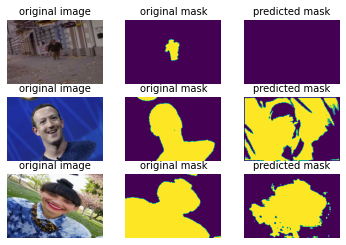

In [ ]:
test_data = CustomDataset(image_dir=TEST_IMG_DIR,
                         mask_dir=TEST_MASK_DIR,
                         transform=train_transform)

test_loader = DataLoader(test_data, batch_size=1)

predict_img(test_loader, MODEL_PATH)

## Reference


*   Dive into Deep Learning

    https://d2l.ai/
*   Deep Learning
    
    https://www.deeplearningbook.org/

*   U-Net: Training Image Segmentation Models in PyTorch

    https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

*   Deep Learning with PyTorch : Image Segmentation

    https://www.coursera.org/projects/deep-learning-with-pytorch-image-segmentation

*   PyTorch Image Segmentation Tutorial with U-NET

    https://www.youtube.com/watch?v=IHq1t7NxS8k